In [1]:
import numpy as np
import matplotlib.pylab as plt
import pulp

# Question 1

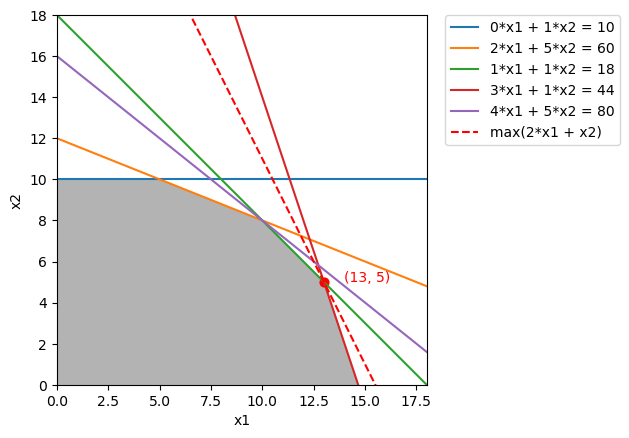

In [17]:
A = [[0, 1], [2, 5], [1, 1], [3, 1], [4, 5], [-1, 0], [0, -1]]
B = [10, 60, 18, 44, 80, 0, 0]

# plot feasible region
d = np.linspace(0, 18, 1000)
x1, x2 = np.meshgrid(d, d)
plt.imshow(eval(f"({'&'.join([f'({a[0]}*x1 + {a[1]}*x2 <= {b})' for a, b in zip(A, B)])}).astype(int)"),
           extent=(x1.min(), x1.max(), x2.min(), x2.max()), origin="lower", cmap="Greys", alpha=0.3)

# plot constraints
x1 = np.linspace(0, 18, 1000)
for a, b in zip(A[:-2], B[:-2]):
    x2 = (b - a[0]*x1)/a[1]
    plt.plot(x1, x2, label=f'{a[0]}*x1 + {a[1]}*x2 = {b}')

# plot objective function
x2 = 31 - 2*x1
plt.plot(x1, x2, label=f'max(2*x1 + x2)', color="red", linestyle='dashed')
plt.scatter([13,],[5,], marker="o", color="red", s=40)
plt.annotate("(13, 5)", (13,5), xytext=(14,5), color="red")

plt.xlim(0,18)
plt.ylim(0,18)
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


# Question 2